In [1]:
import pandas as pd
import numpy as np
import pydicom as dicom
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2 as cv
from concurrent.futures import ProcessPoolExecutor

In [2]:
data_path = Path('rsna-pneumonia-detection-challenge')

### Labels data

In [13]:
labels_path = data_path / 'stage_2_train_labels.csv'

In [14]:
labels = pd.read_csv(labels_path)

In [15]:
labels.shape

(30227, 6)

- Total records = 30227

In [16]:
labels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


- Total 6 columns
- 1 for id
- 4 for position of box
- 1 for Target variable

In [17]:
labels['patientId'].nunique()

26684

- Total patients = 26684
- A patient may have multiple records corresponding to each - area

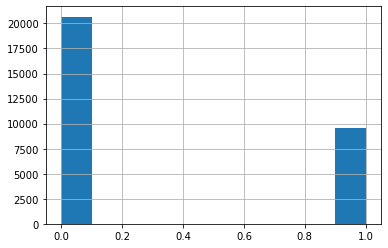

In [18]:
labels['Target'].hist();

In [19]:
np.bincount(labels['Target'])

array([20672,  9555], dtype=int64)

- 0 (not infected) -- 20672
- 1 (infected)     -- 9555

### Class info

In [20]:
class_info_path = data_path / 'stage_2_detailed_class_info.csv'

In [21]:
class_info = pd.read_csv(class_info_path)

In [22]:
class_info.shape

(30227, 2)

In [23]:
class_info.head(2)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal


In [24]:
class_info['patientId'].nunique()

26684

### A patient may fall into any of the 3 categories:
#### label-1
- having Pneumonia, 

##### label-0
- not having Pneumonia and normal
- not having Pneumonia and not-normal/no-lung-opacity

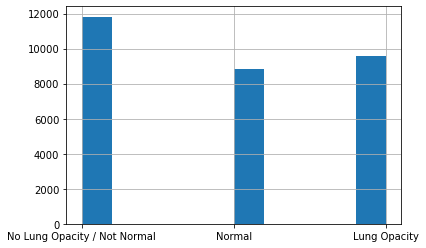

In [25]:
class_info['class'].hist();

- Not Normal ~ 12000
- Normal ~ 9000
- Lung Opacity ~ 9500

### Image data

In [3]:
images_path = data_path / 'stage_2_train_images'

In [4]:
n_patient = len(os.listdir(images_path))
n_patient

26684

In [5]:
filename = os.listdir(images_path)[0]

file = dicom.dcmread(images_path / filename)

In [6]:
file.dir()

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

In [7]:
file.pixel_array.shape

(1024, 1024)

- It is a 1024x1024 dimensional 2-D image. We might perhaps need to reshape the data appropriately.

### save images as JPEG format in a separate folder [OPTIONAL]

In [8]:
# folder_name = 'stage_2_train_images_jpeg'

In [9]:
# if folder_name not in os.listdir(data_path):
#     os.mkdir(data_path / folder_name)

In [10]:
# def dcm_to_jpeg(filename):
#     file = dicom.dcmread(images_path / filename)
#     filename = filename.split('.')[0] + '.jpeg'
#     jpeg = np.stack((file.pixel_array,) * 3, axis=2)
#     cv.imwrite(str(data_path / folder_name / filename), jpeg)

# with ProcessPoolExecutor() as executor:
#     executor.map(dcm_to_jpeg, os.listdir(images_path))

In [23]:
def get_age_gender(filename):
    '''Returns: tuple, containing age and gender corresponding to filename'''
    file = dicom.dcmread(images_path / filename)
    return (file.PatientAge, file.PatientSex)

In [24]:
# Using python built-in Multi-Processing API to load age and gender
with ProcessPoolExecutor() as executor:
    a = list(executor.map(get_age_gender, os.listdir(images_path)))

In [25]:
age_gender = pd.DataFrame(a, columns=['age', 'gender'])

In [26]:
age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     26684 non-null  object
 1   gender  26684 non-null  object
dtypes: object(2)
memory usage: 417.1+ KB


In [27]:
age_gender['age'] = age_gender['age'].astype('int8')

In [28]:
age_gender.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26684.0,46.982049,16.877806,-108.0,34.0,49.0,59.0,92.0


In [29]:
(age_gender['age']<0).sum()

5

- 5 negative

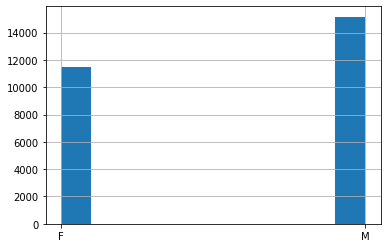

In [30]:
age_gender.gender.hist();

In [11]:
def plot_image(filename):
    'Display x-ray image with bounding boxes (if applicable) correspondin to filename'
    
    # reading dicom file
    file = dicom.dcmread(images_path / filename)
    
    # id is just 'filename' with it's extension(dcm) having removed
    id = filename.split('.')[0]  
    
    # All records corresponding to a particular id
    # Each record contains Target-variable value (1/0) and box-position information
    records = labels[labels['patientId']==id]
    
    fig, ax = plt.subplots(1)
    
    # Whether this patient (this id) is pneumonic or not
    if (len(records)==1 and records['Target'].values[0]==0):
        has_pneumonia = False
    else:
        has_pneumonia = True

    # If pneumonic then draw the bbox as well else only plot the image
    if has_pneumonia:
        # Iterating over all the records to get bbox
        for i, s in records.iloc[:, 1:5].iterrows():
            bbox = Rectangle((s['x'], s['y']), s['width'], s['height'], color='blue',
                             fill=False)
            ax.add_patch(bbox)
        ax.imshow(file.pixel_array, cmap='gray')
        print(s['y'])
    else:
        ax.imshow(file.pixel_array, cmap='gray')
    
    # which class (of the total 3 classes) does this id belong to
    c = class_info[class_info['patientId'] == id]['class'].values[0]
    ax.set_xlabel(c)

375.0
227.0
164.0
375.0
230.0


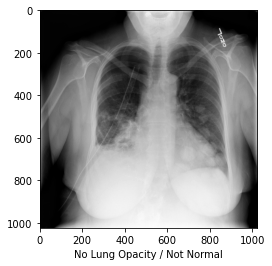

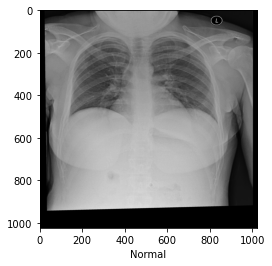

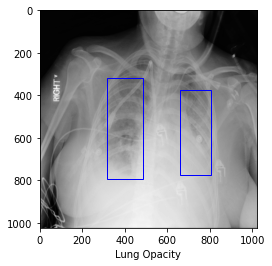

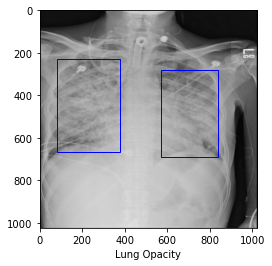

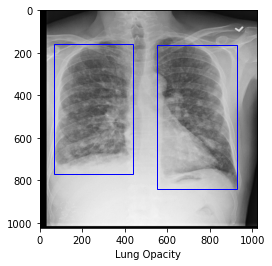

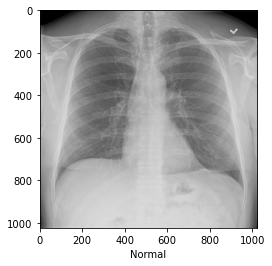

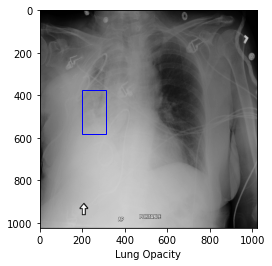

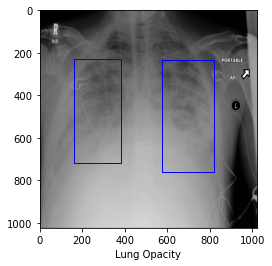

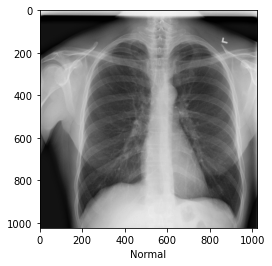

In [26]:
for i in range(9):
    filename = os.listdir(images_path)[i]
    plot_image(filename)

In [ ]:
# ploting 5 random scans
for _ in range(5):
    n = np.random.randint(n_patient)
    filename = os.listdir(images_path)[n]
    plot_image(filename)